In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

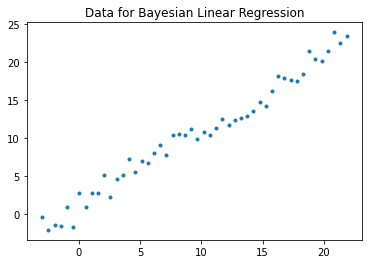

In [ ]:
def generate_data(n=100, sd=1, xlims=[-3,6*np.pi+3], seed=1,
                  f = lambda x: 1 + x + np.sin(x/3)*(x>0)*(x<6*np.pi)):
    '''
    This version more accurately reflects the functional relationship?
    `np.sin(x/3)*(x>0)*(x<6*np.pi))` is not intuitive feature engineering
    and without specifying this correctly the linear specification is wrong
    and subsequently the normality assumptions of the model are incorrect.

    Are you sure you want to introduce correlated errors into the analysis?
    '''

    np.random.seed(seed)
    x = np.linspace(*xlims, n)
    y = f(x) + np.random.normal(0, sd, n)
    return x,y

x, y = generate_data(50)
plt.plot(x, y, '.')
plt.title("Data for Bayesian Linear Regression")
plt.show()

## Gaussian Process with a exponential quadratic kernel

In [ ]:
import pymc3 as pm

X = x[:, np.newaxis]

with pm.Model() as gp_model:
  # Use a exponential quadratic kernel
  ita = pm.HalfNormal('ita', sigma=5)
  iota = pm.Gamma('iota', alpha=4, beta=2)

  sq_exp = ita ** 2 * pm.gp.cov.ExpQuad(input_dim=1, ls=iota)

  gp = pm.gp.Marginal(cov_func=sq_exp)

  sigma = pm.HalfNormal('sigma', sigma=5, testval=1)
  y_ = gp.marginal_likelihood('y', X=X, y=y, noise=sigma)

In [ ]:
with gp_model:
  tr = pm.sample(target_accept=0.95, return_inferencedata=True)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, iota, ita]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 914 seconds.


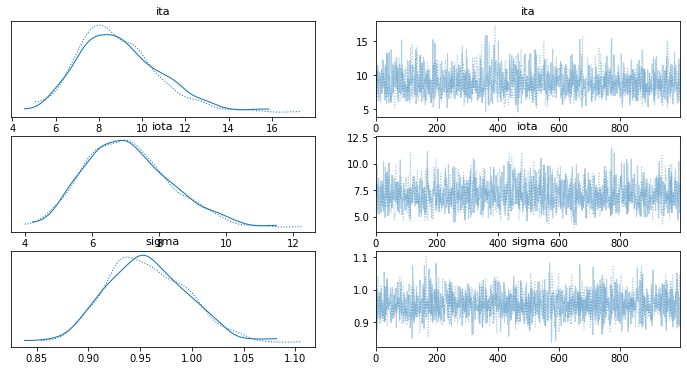

In [ ]:
import arviz as az

az.plot_trace(tr, var_names=['ita', 'iota', 'sigma'])
plt.show()

In [ ]:
Xnew = np.linspace(-8 , 6*np.pi+8, 100)

with gp_model:
  pred = gp.conditional("pred1", Xnew=Xnew[:, np.newaxis])

with gp_model:
  ppred = pm.sample_posterior_predictive(tr, samples=100, var_names=['pred1'])

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


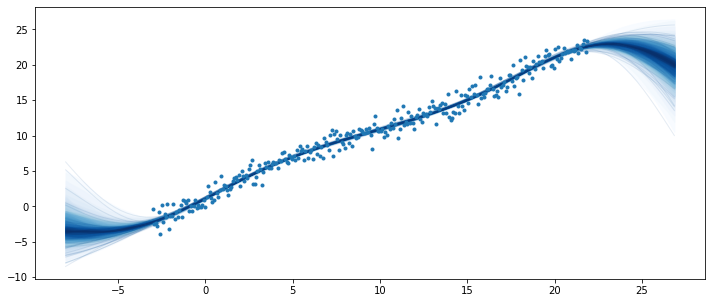

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, ppred['pred1'], Xnew, plot_samples=True, palette='Blues')
ax.plot(X, y, '.')

## Guassian process with a rational quadratic kernel (with one additional parameter)

In [ ]:
import pymc3 as pm

X = x[:, np.newaxis]

with pm.Model() as gp_model:
  # Use a rational quadratic kernel
  ita = pm.HalfNormal('ita', sigma=5)
  iota = pm.Gamma('iota', alpha=4, beta=2)
  alpha = pm.Gamma('alpha', alpha=3, beta=1)
  cov = ita ** 2 * pm.gp.cov.RatQuad(1, alpha, iota)

  gp = pm.gp.Marginal(cov_func=cov)

  sigma = pm.HalfNormal('sigma', sigma=5, testval=1)
  y_ = gp.marginal_likelihood('y', X=X, y=y, noise=sigma)

In [ ]:
with gp_model:
  tr = pm.sample(target_accept=0.95, return_inferencedata=True)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, alpha, iota, ita]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1859 seconds.


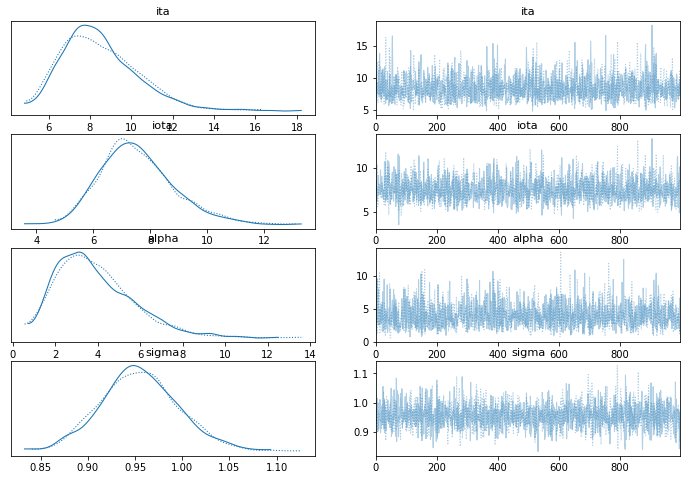

In [ ]:
az.plot_trace(tr, var_names=['ita', 'iota', 'alpha', 'sigma'])
plt.show()

In [ ]:
Xnew = np.linspace(-8 , 6*np.pi+8, 100)

with gp_model:
  pred = gp.conditional("pred1", Xnew=Xnew[:, np.newaxis])

with gp_model:
  ppred = pm.sample_posterior_predictive(tr, samples=100, var_names=['pred1'])



/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


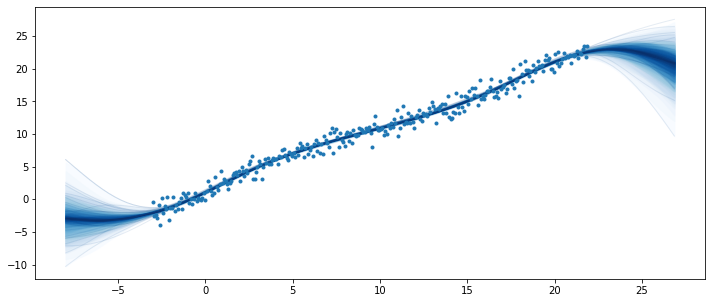

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, ppred['pred1'], Xnew, plot_samples=True, palette='Blues')
ax.plot(X, y, '.')

In [ ]:
# MC-Dropout


nonlinear_f = lambda x: np.sin(x/3)*(x>0)*(x<6*np.pi)
psiX = np.concatenate([1+0*x[:,np.newaxis], 
                       x[:,np.newaxis], nonlinear_f(x[:,np.newaxis])],axis=1)
  
def neg_loglik(target, pred_distribution):
  return -pred_distribution.log_prob(target)


def fit_dropout(p):
  
  batch_size = 32

  inputs = layers.Input(shape=(3,))
  features = layers.Dense(20, activation='relu')(inputs)
  features = layers.Dropout(p)(features, training=True)
  features = layers.Dense(20, activation='relu')(features)
  features = layers.Dropout(p)(features, training=True)

  params = layers.Dense(1)(features)
  # params = layers.Dropout(0.1)(params)

  pred_distribution = tfp.layers.DistributionLambda(
      lambda params: tfp.distributions.Normal(loc=params[:,0:1], scale=1)
  )(params)
  model_Dropout = tf.keras.Model(inputs=inputs, outputs=pred_distribution)
  model_Dropout.compile(tf.keras.optimizers.Adam(), loss=neg_loglik)
  hist = model_Dropout.fit(psiX, y, epochs=500, verbose=0, batch_size=batch_size)

  return model_Dropout, hist

In [ ]:
# test for Dropout
def test(model_Dropout):
  x_test = np.linspace(-8 , 6*np.pi+8, 100)

  psiX_test = np.concatenate([1+0*x_test[:,np.newaxis], 
                        x_test[:,np.newaxis], nonlinear_f(x_test[:,np.newaxis])],axis=1)

  predictions = []
  for i in range(50):
    predictions.append(model_Dropout.predict(psiX_test))
  predictions = np.array(predictions)
  mu = np.squeeze(np.mean(predictions, axis=0))
  std = np.squeeze(np.std(predictions, axis=0))

  plt.plot(x_test, mu, label="Mean prediction")
  plt.fill_between(x_test, mu - 2*std, mu + 2 * std, alpha=0.2)
  plt.axvline(-3, color='r')
  plt.axvline(6*np.pi+3, color='r')
  plt.title("Prediction of VI model")
  plt.show()

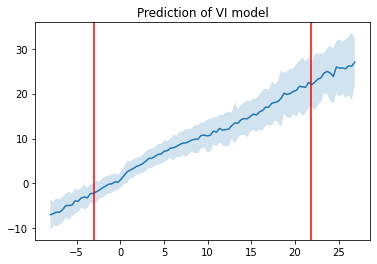

In [ ]:
model1, hist1 = fit_dropout(p=0.1)
test(model1)

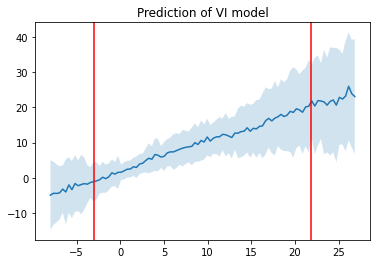

In [ ]:
model2, hist2 = fit_dropout(p=0.5)
test(model2)

### Property of $p$

As the dropout probability increases,

* (aleatoric) uncertainty is large when far from the observed data. 

* output uncertainty increases